# ManualAIze development

In [1]:
import os
import getpass
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser 
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools



In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [4]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")


In [5]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Certification - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Let's start building the agent

This agent main goal is to parse and retrieve information from user manuals uploaded by the user. The first step will always be retrieval potentially augmented by internet searches. The outile of the agentic loop is the following

1. User uploads pdfs 
2. User inputs a question
3. Agent cycle starts
    - a. retrieve most relevant information from the uploaded pdfs
    - b. router agent evaluates if there is enough context
        - i. if not, calls tavily search
    - c. once it has enough context calls the writer node

### Set up the retrieval node
Let's start with parsing, embedding and storing the pdfs using Qdrant

In [6]:
import glob
import time
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Get all PDF files in the data directory
pdf_files = glob.glob("./data/*.pdf")
print(f"Found {len(pdf_files)} PDF files:")
for file in pdf_files:
    print(f"  - {file}")

# Load all PDF files with PyPDF (much faster!)
all_documents_pypdf = []
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

for pdf_file in pdf_files:
    try:
        print(f"\nLoading {pdf_file}...")
        start_time = time.time()
        
        # PyPDFLoader is MUCH faster than UnstructuredPDFLoader
        loader = PyPDFLoader(pdf_file)
        pages = loader.load()
        
        # Split into smaller chunks for better retrieval
        documents = text_splitter.split_documents(pages)
        
        elapsed = time.time() - start_time
        all_documents_pypdf.extend(documents)
        print(f"✓ Loaded {len(pages)} pages → {len(documents)} chunks in {elapsed:.1f}s")
        
    except Exception as e:
        print(f"✗ Error loading {pdf_file}: {e}")

print(f"\nTotal documents: {len(all_documents_pypdf)}")

Found 3 PDF files:
  - ./data/2024-odyssey.pdf
  - ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf
  - ./data/2022-mazda-mazda6.pdf

Loading ./data/2024-odyssey.pdf...
✓ Loaded 702 pages → 1210 chunks in 24.4s

Loading ./data/foonf_2024_manual_US_EN_02_27_2024_WEB_Final.pdf...
✓ Loaded 100 pages → 143 chunks in 3.3s

Loading ./data/2022-mazda-mazda6.pdf...
✓ Loaded 702 pages → 1466 chunks in 10.9s

Total documents: 2819


In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    all_documents_pypdf,
    embeddings,
    location=":memory:",
    collection_name="Manuals"
)

### Now let's create the retrieval node

This is not RAG. I want this node to just fetch the information

In [8]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

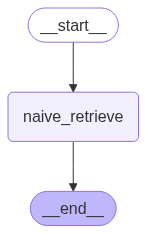

In [9]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class RetrievalState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

def naive_retrieve(state: RetrievalState) -> RetrievalState:
    retrieved_docs = naive_retriever.invoke(state["messages"][-1].content)  # Get question from last message
    
    # Convert Documents to messages
    context_message = f"Retrieved context from documents:\n"
    for i, doc in enumerate(retrieved_docs):
        context_message += f"\n--- Document {i+1} ---\n{doc.page_content}\n"
    
    return {
        "messages": [
            HumanMessage(content="Retrieval agent responding:"),
            AIMessage(content=context_message, name="Retrieval")
        ]
    }

def compression_retrieve(state: RetrievalState) -> RetrievalState:
    retrieved_docs = naive_retriever.invoke(state["messages"][-1].content)  # Get question from last message
    
    # Convert Documents to messages
    context_message = f"Retrieved context from documents:\n"
    for i, doc in enumerate(retrieved_docs):
        context_message += f"\n--- Document {i+1} ---\n{doc.page_content}\n"
    
    return {
        "messages": [
            HumanMessage(content="Retrieval agent responding:"),
            AIMessage(content=context_message, name="Retrieval")
        ]
    }

graph_builder = StateGraph(RetrievalState)
graph_builder = graph_builder.add_sequence([naive_retrieve])
graph_builder.add_edge(START, "naive_retrieve")
retrieval_graph = graph_builder.compile()

retrieval_graph

In [ ]:
def retrieval_enter_chain(question: str):
    return {
        "messages": [HumanMessage(content=question["question"])],
        "team_members": ["Search", "Writer"],
        "next": ""
    }

full_test_chain = retrieval_enter_chain | retrieval_graph

full_test_chain.invoke({"question" : "What are the front facing height and weight limits for the car seat?"})

{'messages': [HumanMessage(content='What are the front facing height and weight limits for the car seat?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Retrieved context from documents:\n\n--- Document 1 ---\n15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Tether.\nNOTE: If child weighs more than 35 lb \n(15.9 kg), this car seat must be installed \neither with the vehicle belt and the Top \nTether or with the rigid LATCH lower \nconnectors, the vehicle belt, and the \nTop Te

In [ ]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset(eval_dataset)

### Helper functions
Now I am going to create helper functions to help me quickly build the nodes, the graph and the connections between them.We will have our helper accepts the following parameters:


- llm: the llm that will power this agent node
- tools: the list of tools available to the llm
- system_prompt: the system prompt to attach to the llm to ground its generation

In [12]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the actual output text from the agent result
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
    else:
        output_text = str(result)
    
    # Return two messages: one identifying the agent, one with its response
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=output_text, name=name)
        ]
    }

In [13]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [14]:
def create_router(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    
    tool_def = {
        "type": "function",
        "function": {
            "name": "route",
            "description": "Select the next role.",
            "parameters": {
                "type": "object",
                "properties": {
                    "next": {
                        "type": "string",
                        "enum": options,
                    },
                },
                "required": ["next"],
            },
        }
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    
    
    return (
        prompt
        | llm.bind_tools([tool_def], tool_choice={"type": "function", "function": {"name": "route"}})
        | JsonOutputToolsParser()
    )

### Create the tools
For this application we need only tavily.

Tavily search for which we can just pull the implemented API from the library. 

If we were to create a custom tool we would just need to define  a function that calls the node and add the tool decorator. There is an example below, however we are not going to use it

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
]

/var/folders/6m/hq4dj_jn0l96rctpr1_nhgyr0000gn/T/ipykernel_25211/3644306814.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [16]:
@tool
def search_internet(query: Annotated[str, "Query to search the internet for"]):
    """Search the internet for additional information"""
    # Use your existing tavily_tool
    results = tavily_tool.invoke(query)
    
    # Convert results to Document format
    from langchain_core.documents import Document
    docs = []
    for result in results:
        content = f"Title: {result.get('title', '')}\nContent: {result.get('content', '')}\nURL: {result.get('url', '')}"
        docs.append(Document(page_content=content, metadata={"source": "internet_search", "url": result.get('url', '')}))
    
    return docs

### Let's define the state functions

First let's define what we want to keep track of at every step of the execution.

- messages: The messages we've passed so far
- team_members: which team members we have access to
- next: what team member is up next

### Now it is time to define the orchestrator node, the router in this case

The router will receive the context from the retrieval and then decide whether it should call tavily or pass the context directly to the writer

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### It is finally time to define the agents
As a recap, we need:
- a retrieval node, which we already have
- a router/orchestrator agent that can either call the search or writer agent
- a search agent
- a writer agent

In [18]:
search_agent = create_agent(
    llm, 
    [search_internet], 
    "You are a research assistant who can search for details to asnwer the user query."
    )

# search_node = functools.partial(agent_node, agent=search_agent, name="Search")

def search_agent_node(state, agent, name):
    result = agent.invoke(state)
    
    # Extract the search results (already Documents from your tool)
    if isinstance(result, dict):
        output_text = result.get('output', str(result))
        # If output contains Documents, format them
        if hasattr(result.get('output'), '__iter__') and all(hasattr(item, 'page_content') for item in result.get('output')):
            search_message = f"Internet search results:\n"
            for i, doc in enumerate(result.get('output')):
                search_message += f"\n--- Result {i+1} ---\n{doc.page_content}\n"
        else:
            search_message = output_text
    else:
        search_message = str(result)
    
    return {
        "messages": [
            HumanMessage(content=f"{name} agent responding:"),
            AIMessage(content=search_message, name=name)
        ]
    }

search_node = functools.partial(search_agent_node, agent=search_agent, name="Search")

In [19]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# Create a specific prompt and chain for the writer
# This is a much simpler setup than a full agent
writer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a writer. Use the provided context to answer the user's question clearly and accurately."),
        ("user", "Question: {question}\n\nContext:\n{context}")
    ]
)
writer_chain = writer_prompt | llm | StrOutputParser()

def writer_node(state):
    """
    The writer node. It takes the state, combines the context,
    and generates the final answer.
    """
    # Combine all context from messages
    combined_context = ""
    for msg in state["messages"]:
        if isinstance(msg, AIMessage) and msg.name in ["Retrieval", "Search"]:
            combined_context += f"\n{msg.content}\n"
            
    # The first message is always the user's original question
    question = state["messages"][0].content
    
    # Invoke the writer chain
    result = writer_chain.invoke({"question": question, "context": combined_context})
    
    return {
        "messages": [
            HumanMessage(content="Writer agent responding:"),
            AIMessage(content=result, name="Writer")
        ]
    }

In [21]:
router_agent = create_router(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, Writer. Given the following user request,"
    " determine if the information is enough to answer the user query. If it is,"
    " pass the context to Writer. If it is not, pass the query to Search."
    " You should never ask Search to do anything beyond research."
    " You should never ask Writer to do anything beyond writing the answer given"
    " the context."),
    ["Search", "Writer"],
)

In [22]:
def router_node(state):
    # Extract messages from the state
    messages = state["messages"]
    
    # Call the router chain with proper input
    result = router_agent.invoke({"messages": messages})
    
    # The new parser returns a list of tool calls. We'll take the first one.
    # The result looks like: [{'type': 'route', 'args': {'next': 'Writer'}}]
    # So we access the arguments of the first tool call.
    return {
        **state, 
        "next": result[0]["args"]["next"]
    }

# def router_node(state):
#     # Extract messages from the state
#     messages = state["messages"]
    
#     # Temporarily create a chain without the parser to see the raw output
#     # router_agent is a RunnableSequence, so we can access its parts
#     unparsed_router = router_agent.first | router_agent.middle[0]
    
#     # Let's see what the model is thinking
#     print("--- Router Input Messages ---")
#     for msg in messages:
#         print(msg)
    
#     raw_result = unparsed_router.invoke({"messages": messages})
    
#     print("\n--- Raw Router Output ---")
#     print(raw_result)
#     print("---------------------------\n")

#     # Call the router chain with proper input
#     result = router_agent.invoke({"messages": messages})
    
#     # Extract the routing decision and update state
#     return {
#         **state, 
#         "next": result["next"]
#     }

### Let's assemble the graph!

In [24]:
graph = StateGraph(RetrievalState)

# Add nodes
graph.add_node("Retrieve", naive_retrieve)
graph.add_node("Router", router_node)
graph.add_node("Search", search_node)
graph.add_node("Writer", writer_node)

# Set entry point
graph.set_entry_point("Retrieve")

# Add edges
graph.add_edge("Retrieve", "Router")
graph.add_conditional_edges(
    "Router",
    lambda x: x["next"],
    {
        "Search": "Search",
        "Writer": "Writer",
    }
)
graph.add_edge("Search", "Writer")
graph.add_edge("Writer", END)

# Compile
compiled_graph = graph.compile()

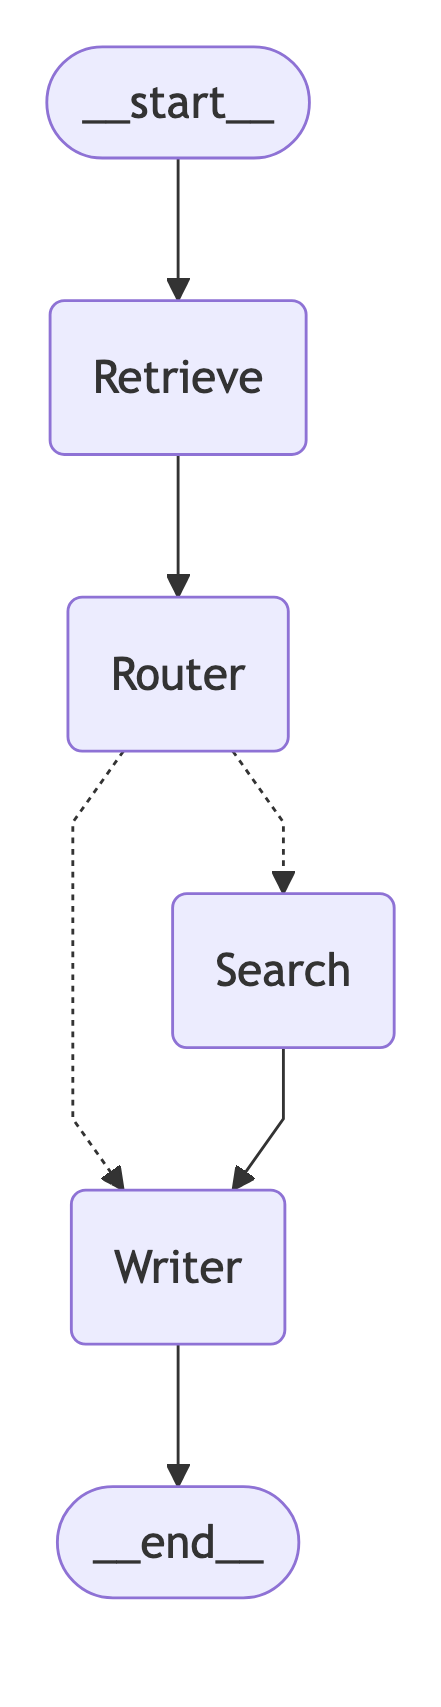

In [25]:
import nest_asyncio
nest_asyncio.apply()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [26]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["Search", "Writer"], 
        "next": "",                           
    }
    return results

research_chain = enter_chain | compiled_graph

In [27]:
for s in research_chain.stream(
    "What is the weight and height limits for the car seat when front facing?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Retrieve': {'messages': [HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}), AIMessage(content='Retrieved context from documents:\n\n--- Document 1 ---\n15\n  When Using This Car Seat \nin Forward-Facing Mode\nP Child’s weight is between 22 and 65 lb \n(10 and 29.5 kg).\nP Child’s height is between 30 and 49 in. \n(76 and 124 cm).\nP Child is at least 1 year of age.\nP Car seat is securely installed in a rear \nvehicle seating position using either the \nrigid LATCH Connectors and the Top \nTether; the vehicle belt and Top Tether; or \nthe rigid LATCH Connectors, the vehicle \nbelt, and the Top Tether.\nNOTE: If child weighs more than 35 lb \n(15.9 kg), this car seat must be installed \neither with the vehicle belt and the Top \nTether or with the rigid LATCH lower \nconnectors, the vehicle belt, and the \nTop Tether. \nP Car Seat is properly assembled with  \nthe headrest properly secured. The  \nRear-Facing Base and Anti-Rebound  \nBar m

In [28]:
for s in research_chain.stream(
    "Where are the lower anchors located in the mazda 6?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Retrieve': {'messages': [HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}), AIMessage(content='Retrieved context from documents:\n\n--- Document 1 ---\nᶕ Armrest..................................................................................................................page 2-16\nᶖ ISOFIX lower anchors (Mexico)/LATCH lower anchors (Except Mexico).........page 2-48\nPictorial Index\nInterior Overview\nThe equipment and installation position varies by vehicle 1-5\nMazda6_8HX3-EA-19I_Edition1_old 2019-6-18 9:25:17\n\n--- Document 2 ---\nUsing LATCH Lower Anchor (Except Mexico)" (page 2-48).\n*1 ISOFIX (Mexico)/LATCH (Except Mexico)\nEssential Safety Equipment\nChild Restraint\n2-35\nMazda6_8HX3-EA-19I_Edition1_old 2019-6-18 9:25:17\n\n--- Document 3 ---\nwebbing) can be used at this seating\nposition only if the child-restraint system\nmanufacturer\'s instructions state that the\nchild-restraint system can be installed to\nISOFIX/LATCH\

In [29]:
for s in research_chain.stream(
    "What is the the capital of France?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Retrieve': {'messages': [HumanMessage(content='Retrieval agent responding:', additional_kwargs={}, response_metadata={}), AIMessage(content="Retrieved context from documents:\n\n--- Document 1 ---\n1. Select the  icon to display the\nFavorites list.\n2. Select .\n3. Select .\n4. The station is added to the bottom of\nthe Favorites list.\nNOTE\nIf the battery is disconnected, your\nFavorites list will not be deleted.\nSelecting radio station from Favorites\n1. Select the  icon to display the\nFavorites list.\n2. Select the radio frequency to tune in\nthe radio station.\nDeleting from Favorites\n1. Select the  icon to display the\nFavorites list.\n2. Select .\n3. Select .\n4. Select the radio frequency you want to\ndelete.\n5. Select .\nChanging Favorites list order\n1. Select the  icon to display the\nFavorites list.\n2. Select .\n3. Select .\n4. Select a radio frequency. The selected\nradio station can be moved.\n5. Slide the radio station or move it using\nthe commander switch, then

### IT WORKS!

# Now on to evaluating the agent's performance with RAGAS
The plan is to
- create the golden dataset
- define metrics for evaluation
- instantiate two versions of the graph, one with naive retrieval and one with context retrieval
- evaluate them both
- compare the metrics for the two strategies and identify the best one

### Load the pdf files to parse and generate data from 

In [30]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

In [31]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [33]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
ragas_dataset = generator.generate_with_langchain_docs(docs[:100], testset_size=10)

Applying SummaryExtractor:   0%|          | 0/87 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 0c9ba0af-7e5c-4d7c-98d8-c8060e849c2f does not have a summary. Skipping filtering.
Node 2f203270-2bc7-4c95-920e-7c5c7e000d53 does not have a summary. Skipping filtering.
Node 12f8d571-957c-4312-9aad-be55314b6c25 does not have a summary. Skipping filtering.
Node 2552e4cb-040e-4031-a82c-d907e2b440b6 does not have a summary. Skipping filtering.
Node 7943d0ba-6e36-4229-a6f0-44f1b991c217 does not have a summary. Skipping filtering.
Node 32f316ef-4d8a-4e4a-9d96-e1b2f0ea31c4 does not have a summary. Skipping filtering.
Node 8d3f3ba1-8455-4a0b-b173-1aaa6c9d4f6c does not have a summary. Skipping filtering.
Node 61466774-ce75-461d-ab9a-9097d2130d26 does not have a summary. Skipping filtering.
Node 755a6f16-48e4-42fd-be34-73eb1d517fba does not have a summary. Skipping filtering.
Node 7e4339b0-0413-4886-8efc-dbd2759e68af does not have a summary. Skipping filtering.
Node f3d30d68-8163-463b-9dc0-fd05f61c6f35 does not have a summary. Skipping filtering.
Node 279cb417-5cca-44ba-b789-4dc1658434c7 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/287 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [34]:
ragas_dataset.to_pandas()


,user_input,reference_contexts,reference,synthesizer_name
0,What is 2024 ODYSSEY?,[2024 ODYSSEY\nOwner’s Manual],2024 ODYSSEY is referenced in the Owner’s Manu...,single_hop_specifc_query_synthesizer
1,Can you tell me what an EDR is and how it help...,[Event Data Recorders\nThis vehicle is equippe...,"An EDR, or Event Data Recorder, is a device eq...",single_hop_specifc_query_synthesizer
2,Honda what do I need to check?,[These data can help provide a better understa...,The context provided does not contain specific...,single_hop_specifc_query_synthesizer
3,What role does Honda Automobile Customer Servi...,[Software End User License Agreement\nYour veh...,Honda Automobile Customer Service is involved ...,single_hop_specifc_query_synthesizer
4,H0w do inflation pr0cess and saftey consideera...,[<1-hop>\n\n52\nuuAirbagsuTypes of Airbags\nSa...,The provided context discusses the different t...,multi_hop_abstract_query_synthesizer
5,Wht do I need to check for protection during s...,[<1-hop>\n\n66\nuuAirbagsuAirbag Care\nSafe Dr...,"To ensure protection during a side impact, it ...",multi_hop_abstract_query_synthesizer
6,How do driver assistance functions like Honda ...,[<1-hop>\n\n28\nQuick Reference Guide\nHonda S...,Driver assistance functions such as Honda Sens...,multi_hop_abstract_query_synthesizer
7,How does the indicator light related to brake ...,[<1-hop>\n\n88\nInstrument Panel\nIndicators\n...,The indicator light for low brake fluid level ...,multi_hop_abstract_query_synthesizer
8,how do driver and driver seatbelt system compo...,[<1-hop>\n\n21\nQuick Reference Guide\nFan Con...,The context describes various safety component...,multi_hop_specific_query_synthesizer
9,How do proper seat belt use and correct seatin...,[<1-hop>\n\n47\nuuSeat BeltsuFastening a Seat ...,The safety inspector emphasizes that wearing s...,multi_hop_specific_query_synthesizer


In [35]:

from langchain_core.messages import AIMessage, BaseMessage
from typing import List

def extract_contexts_from_messages(messages: List[BaseMessage]) -> List[str]:
    """
    Extracts the content from all AIMessages that served as context.
    
    In this agent, the 'Retrieval' and 'Search' nodes produce the context
    used by the 'Writer' node. This function collects the content from the
    messages produced by these nodes.
    """
    contexts = []
    for message in messages:
        # We identify context messages by checking if they are AIMessages
        # and if their 'name' attribute is either 'Retrieval' or 'Search'.
        if isinstance(message, AIMessage) and hasattr(message, 'name') and message.name in ["Retrieval", "Search"]:
            contexts.append(message.content)
    return contexts
    


In [36]:
from langchain_core.messages import HumanMessage
from datasets import Dataset
import pandas as pd

# Convert the ragas testset to a pandas DataFrame to iterate over it
test_df = ragas_dataset.to_pandas()

results_list = []

# Iterate over each question in the test set
for index, row in test_df.iterrows():
    # As you correctly pointed out, the question from the Ragas TestsetGenerator
    # is in the 'user_input' column.
    question = row["user_input"]
    
    # Run the agent to get the answer and the context used
    inputs = {"messages": [HumanMessage(content=question)]}
    response = compiled_graph.invoke(inputs, {"recursion_limit": 100})
    
    # The final answer is the content of the last message from the Writer node
    answer = response["messages"][-1].content
    
    # The context is all the information gathered by the Retrieval and Search nodes.
    contexts = extract_contexts_from_messages(response["messages"])
    
    # The Ragas evaluate function expects a 'ground_truth' column.
    # From your output, the generated ground truth is in the 'reference' column.
    results_list.append(
        {
            "question": question,
            "answer": answer,
            "contexts": contexts,
            "ground_truth": row["reference"], 
        }
    )

# Create a new Hugging Face Dataset from our results
# This is the format Ragas expects for evaluation
eval_dataset = Dataset.from_list(results_list)

# Display the first few rows to verify the final structure
pd.DataFrame(eval_dataset)


,question,answer,contexts,ground_truth
0,What is 2024 ODYSSEY?,The 2024 ODYSSEY refers to the latest model of...,[Retrieved context from documents:\n\n--- Docu...,2024 ODYSSEY is referenced in the Owner’s Manu...
1,Can you tell me what an EDR is and how it help...,An Event Data Recorder (EDR) is a device insta...,[Retrieved context from documents:\n\n--- Docu...,"An EDR, or Event Data Recorder, is a device eq..."
2,Honda what do I need to check?,"When checking your Honda vehicle, here are the...",[Retrieved context from documents:\n\n--- Docu...,The context provided does not contain specific...
3,What role does Honda Automobile Customer Servi...,Honda Automobile Customer Service plays a cruc...,[Retrieved context from documents:\n\n--- Docu...,Honda Automobile Customer Service is involved ...
4,H0w do inflation pr0cess and saftey consideera...,The relationship between the inflation process...,[Retrieved context from documents:\n\n--- Docu...,The provided context discusses the different t...
5,Wht do I need to check for protection during s...,"To ensure protection during a side impact, you...",[Retrieved context from documents:\n\n--- Docu...,"To ensure protection during a side impact, it ..."
6,How do driver assistance functions like Honda ...,Driver assistance functions like Honda Sensing...,[Retrieved context from documents:\n\n--- Docu...,Driver assistance functions such as Honda Sens...
7,How does the indicator light related to brake ...,The indicator light related to brake fluid lev...,[Retrieved context from documents:\n\n--- Docu...,The indicator light for low brake fluid level ...
8,how do driver and driver seatbelt system compo...,The driver and driver seatbelt system componen...,[Retrieved context from documents:\n\n--- Docu...,The context describes various safety component...
9,How do proper seat belt use and correct seatin...,Proper seat belt use and correct seating posit...,[Retrieved context from documents:\n\n--- Docu...,The safety inspector emphasizes that wearing s...


In [37]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))

In [38]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360, max_workers=1)

result = evaluate(
        dataset=eval_dataset,
        metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
        llm=evaluator_llm,
        run_config=custom_run_config
    )

result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.7111, 'faithfulness': 0.7682, 'factual_correctness(mode=f1)': 0.3283, 'answer_relevancy': 0.9420, 'context_entity_recall': 0.2098, 'noise_sensitivity(mode=relevant)': 0.4966}

### Let's test the compression retrieval

In [39]:
compression_graph_builder = StateGraph(RetrievalState)
compression_graph_builder = compression_graph_builder.add_sequence([compression_retrieve])
compression_graph_builder.add_edge(START, "compression_retrieve")
compression_retrieval_graph = compression_graph_builder.compile()


In [40]:
comp_graph = StateGraph(RetrievalState)

# Add nodes
comp_graph.add_node("Retrieve", compression_retrieve)
comp_graph.add_node("Router", router_node)
comp_graph.add_node("Search", search_node)
comp_graph.add_node("Writer", writer_node)

# Set entry point
comp_graph.set_entry_point("Retrieve")

# Add edges
comp_graph.add_edge("Retrieve", "Router")
comp_graph.add_conditional_edges(
    "Router",
    lambda x: x["next"],
    {
        "Search": "Search",
        "Writer": "Writer",
    }
)
comp_graph.add_edge("Search", "Writer")
comp_graph.add_edge("Writer", END)

# Compile
compiled_comp_graph = comp_graph.compile()

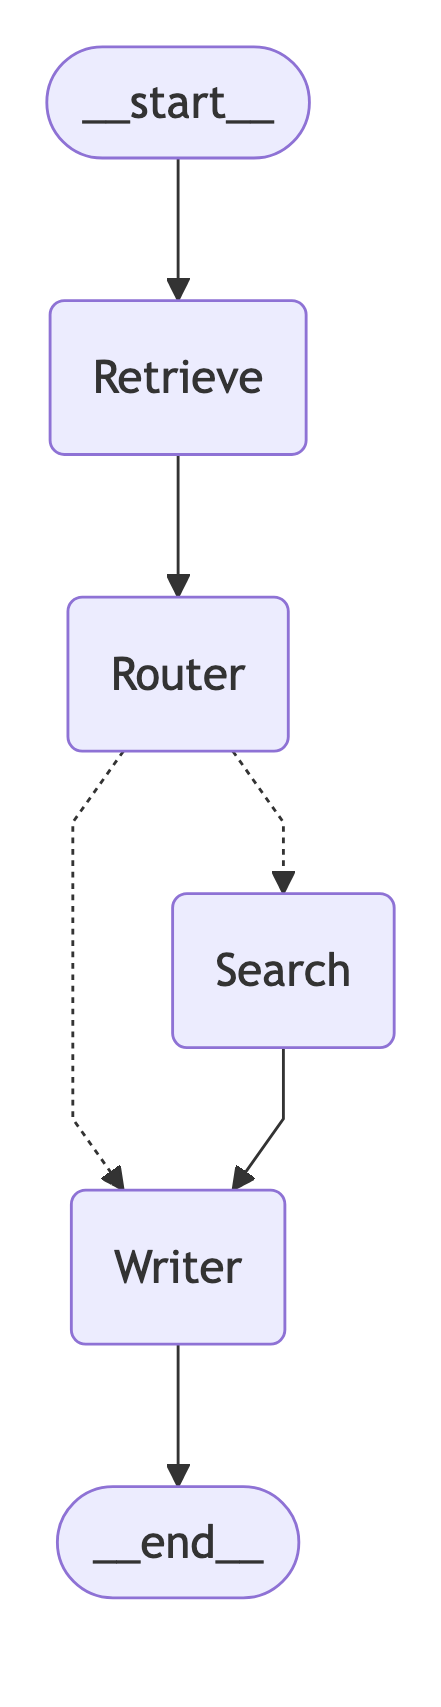

In [41]:
import nest_asyncio
nest_asyncio.apply()

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_comp_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [42]:
from langchain_core.messages import HumanMessage
from datasets import Dataset
import pandas as pd

# Convert the ragas testset to a pandas DataFrame to iterate over it
test_df = ragas_dataset.to_pandas()

results_list = []

# Iterate over each question in the test set
for index, row in test_df.iterrows():
    # As you correctly pointed out, the question from the Ragas TestsetGenerator
    # is in the 'user_input' column.
    question = row["user_input"]
    
    # Run the agent to get the answer and the context used
    inputs = {"messages": [HumanMessage(content=question)]}
    response = compiled_comp_graph.invoke(inputs, {"recursion_limit": 100})
    
    # The final answer is the content of the last message from the Writer node
    answer = response["messages"][-1].content
    
    # The context is all the information gathered by the Retrieval and Search nodes.
    contexts = extract_contexts_from_messages(response["messages"])
    
    # The Ragas evaluate function expects a 'ground_truth' column.
    # From your output, the generated ground truth is in the 'reference' column.
    results_list.append(
        {
            "question": question,
            "answer": answer,
            "contexts": contexts,
            "ground_truth": row["reference"], 
        }
    )

# Create a new Hugging Face Dataset from our results
# This is the format Ragas expects for evaluation
comp_eval_dataset = Dataset.from_list(results_list)

# Display the first few rows to verify the final structure
pd.DataFrame(comp_eval_dataset)


,question,answer,contexts,ground_truth
0,What is 2024 ODYSSEY?,The 2024 ODYSSEY refers to the latest model of...,[Retrieved context from documents:\n\n--- Docu...,2024 ODYSSEY is referenced in the Owner’s Manu...
1,Can you tell me what an EDR is and how it help...,An Event Data Recorder (EDR) is a device insta...,[Retrieved context from documents:\n\n--- Docu...,"An EDR, or Event Data Recorder, is a device eq..."
2,Honda what do I need to check?,"When checking your Honda vehicle, here are the...",[Retrieved context from documents:\n\n--- Docu...,The context provided does not contain specific...
3,What role does Honda Automobile Customer Servi...,Honda Automobile Customer Service plays a cruc...,[Retrieved context from documents:\n\n--- Docu...,Honda Automobile Customer Service is involved ...
4,H0w do inflation pr0cess and saftey consideera...,The relationship between the inflation process...,[Retrieved context from documents:\n\n--- Docu...,The provided context discusses the different t...
5,Wht do I need to check for protection during s...,"To ensure protection during a side impact, you...",[Retrieved context from documents:\n\n--- Docu...,"To ensure protection during a side impact, it ..."
6,How do driver assistance functions like Honda ...,Driver assistance functions like Honda Sensing...,[Retrieved context from documents:\n\n--- Docu...,Driver assistance functions such as Honda Sens...
7,How does the indicator light related to brake ...,The indicator light related to brake fluid lev...,[Retrieved context from documents:\n\n--- Docu...,The indicator light for low brake fluid level ...
8,how do driver and driver seatbelt system compo...,The driver and driver seatbelt system componen...,[Retrieved context from documents:\n\n--- Docu...,The context describes various safety component...
9,How do proper seat belt use and correct seatin...,Proper seat belt use and correct seating posit...,[Retrieved context from documents:\n\n--- Docu...,The safety inspector emphasizes that wearing s...


In [43]:
comp_result = evaluate(
        dataset=comp_eval_dataset,
        metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
        llm=evaluator_llm,
        run_config=custom_run_config
    )

comp_result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.6833, 'faithfulness': 0.7699, 'factual_correctness(mode=f1)': 0.3325, 'answer_relevancy': 0.9340, 'context_entity_recall': 0.1582, 'noise_sensitivity(mode=relevant)': 0.4962}

### Let's compare the two retrieval strategies

In [51]:
import pandas as pd
from ragas.evaluation import EvaluationResult

def calculate_metric_delta(
    run1: EvaluationResult, 
    run2: EvaluationResult
) -> dict:
    """
    Calculate the delta between the average scores of two ragas evaluation runs.
    A positive delta means run2 scored higher on average than run1.

    Args:
        run1 (EvaluationResult): First evaluation run result from the naive retriever.
        run2 (EvaluationResult): Second evaluation run result from the compression retriever.

    Returns:
        dict: A dictionary with metric names as keys and their calculated deltas as values.
    """
    delta = {}
    
    # Convert the results to pandas DataFrames for robust access
    df1 = run1.to_pandas()
    df2 = run2.to_pandas()
    
    # Identify common columns between the two dataframes
    common_cols = sorted(list(set(df1.columns).intersection(set(df2.columns))))
    
    print(f"Comparing the following columns: {common_cols}")
    
    # Iterate through common columns and calculate delta for numeric ones
    for metric_name in common_cols:
        # Check if the column is numeric in both DataFrames before calculating mean
        if pd.api.types.is_numeric_dtype(df1[metric_name]) and pd.api.types.is_numeric_dtype(df2[metric_name]):
            # Calculate the mean from the DataFrame column
            avg_score1 = df1[metric_name].mean()
            avg_score2 = df2[metric_name].mean()
            
            # Calculate the difference and round it
            delta[metric_name] = round(avg_score2 - avg_score1, 4)

    return delta

# The function now discovers metric names from the result objects directly.
delta = calculate_metric_delta(result, comp_result)

# Print results
print("\nMetric Deltas (Compression vs. Naive Retrieval):")
# Sorting items for consistent output
for metric, value in sorted(delta.items()):
    print(f"{metric}: {value:+.4f}")

Comparing the following columns: ['answer_relevancy', 'context_entity_recall', 'context_recall', 'factual_correctness(mode=f1)', 'faithfulness', 'noise_sensitivity(mode=relevant)', 'reference', 'response', 'retrieved_contexts', 'user_input']

Metric Deltas (Compression vs. Naive Retrieval):
answer_relevancy: -0.0080
context_entity_recall: -0.0516
context_recall: -0.0278
factual_correctness(mode=f1): +0.0042
faithfulness: +0.0016
noise_sensitivity(mode=relevant): -0.0004
